<a href="https://colab.research.google.com/github/beinghorizontal/Quantext/blob/main/lstm_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas_datareader import data
import datetime as dt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


get free API key from alpha- vantage and save in local file safely and import the file  https://www.alphavantage.co/support/#api-key

In [5]:
from google.colab import files

# Choose the file from your local machine to upload
uploaded = files.upload()


Saving key.txt to key.txt


read the api key file ang get api key

In [ ]:
with open('key.txt', 'r') as f:
  key = f.read()

download the data, nse data wont work but we will use ouw own file for next project anyway

In [12]:
# Download stock market data (e.g., Apple Inc.)
start_date = dt.datetime(2018, 1, 1)
end_date = dt.datetime(2024, 2, 28)
symbol = 'TSLA'  # Ticker symbol for Apple Inc.
df = data.DataReader(symbol, "av-daily", start=datetime(2017, 2, 9),
                    end=datetime(2024, 2, 26),
                    api_key=key)



plot the data

<Axes: >

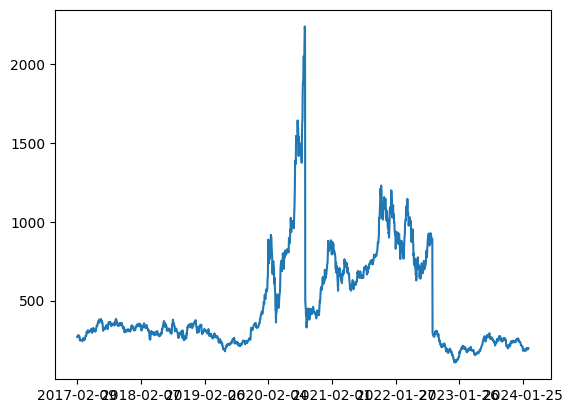

In [13]:
import matplotlib.pyplot as plt
df.close.plot()

transform periodical timeseris data to stationary data by calculating % return

In [15]:
df['Open_pct'] = df['open'].pct_change()
df['High_pct'] = df['high'].pct_change()
df['Low_pct'] = df['low'].pct_change()
df['Close_pct'] = df['close'].pct_change()
df['volume_pct'] = df['volume'].pct_change()

# Drop NaN values
df.dropna(inplace=True)


print df and see columns (features)

In [29]:
from tabulate import tabulate
print(tabulate(df.head(10), headers='keys', tablefmt='fancy_grid'))


╒════════════╤════════╤════════╤════════╤═════════╤═════════════╤═════════════╤══════════════╤══════════════╤══════════════╤══════════════╕
│            │   open │   high │    low │   close │      volume │    Open_pct │     High_pct │      Low_pct │    Close_pct │   volume_pct │
╞════════════╪════════╪════════╪════════╪═════════╪═════════════╪═════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ 2017-02-10 │ 269.79 │ 270.95 │ 266.11 │  269.23 │ 3.61974e+06 │  0.0132958  │ -0.000848145 │ -0.000150291 │  0.000111441 │   -0.537131  │
├────────────┼────────┼────────┼────────┼─────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ 2017-02-13 │ 270.74 │ 280.79 │ 270.51 │  280.6  │ 7.0296e+06  │  0.00352126 │  0.0363163   │  0.0165345   │  0.0422315   │    0.94202   │
├────────────┼────────┼────────┼────────┼─────────┼─────────────┼─────────────┼──────────────┼──────────────┼──────────────┼──────────────┤
│ 2017-02-14 │ 279.0

Give same scale to retun data so it's machine readable


In [52]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Open_pct', 'High_pct', 'Low_pct', 'Close_pct', 'volume_pct']])


In [53]:
# Create sequences of length 10
sequence_length = 2
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    #i=1
    X.append(scaled_data[i:i + sequence_length])
    y.append(1 if df['close'].iloc[i + sequence_length] > df['close'].iloc[i + sequence_length - 1] else 0)

X = np.array(X)
y = np.array(y)


In [ ]:
# Split data into train and validation sets
split_ratio = 0.7
split_index = int(split_ratio * len(X))
X_train, y_train = X[:split_index], y[:split_index]
X_val, y_val = X[split_index:], y[split_index:]



In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, 4), activation='relu'))
model.add(LSTM(64, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
model.add(LSTM(64, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
model.add(LSTM(64, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
model.add(LSTM(64, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
model.add(LSTM(64))  # Last LSTM layer (no return_sequences)
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
train_loss_list = []
val_loss_list = []

# Custom training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Train the model
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))
    train_loss = history.history['loss'][0]
    train_loss_list.append(train_loss)

    # Calculate validation loss (use your validation data)
    # val_loss = model.evaluate(X_val, y_val, verbose=0)
    # val_loss_list.append(val_loss)

    # Update the plot
    plt.clf()  # Clear the previous plot
    plt.plot(train_loss_list, label='Training Loss')
    # plt.plot(val_loss_list, label='Validation Loss')  # Uncomment for validation loss
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.pause(0.01)  # Pause to update the plot

# Show the final plot
plt.show()